# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 
## Homework 3 - Regression Modeling to Forecast Bike Sharing Usage



**Harvard University**<br/>
**Fall 2019**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Chris Tanner

<hr style="height:2pt">

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.
- Please use .head() when viewing data. Do not submit a notebook that is excessively long because output was not suppressed or otherwise limited. 

<hr style="height:2pt">

![bike_sharing](fig/BSS.png)

<div class="theme">  Main Theme: Multiple Linear Regression, Polynomial Regression, Ridge and Lasso Regression </div>
### Overview 

You are hired by the administrators of the [Capital Bikeshare program](https://www.capitalbikeshare.com) program in Washington D.C., to **help them predict the hourly demand for rental bikes** and **give them suggestions on how to increase their revenue**. Your task is to prepare a short report summarizing your findings and make recommendations.

The predicted hourly demand could be used for planning the number of bikes that need to be available in the system at any given hour of the day. It costs the program money if bike stations are full and bikes cannot be returned, or empty and there are no bikes available. You will use multiple linear regression and polynomial regression and will explore ridge and lasso regression to predict bike usage. The goal is to build a regression model that can predict the total number of bike rentals in a given hour of the day, based on all available information given to you. 

An example of a suggestion to increase revenue might be to offer discounts during certain times of the day either during holidays or non-holidays. Your suggestions will depend on your observations of the seasonality of ridership.

The data for this problem were collected from the Capital Bikeshare program over the course of two years (2011 and 2012).



### Use only the libraries below:

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score

from pandas.plotting import scatter_matrix

# Adding just to supress warnings. No other libraries are added
# SRC https://stackoverflow.com/questions/15777951/how-to-suppress-pandas-future-warning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Overview
The initial data set is provided in the file `data/BSS_hour_raw.csv`. You will first add features that will help with the analysis and then separate the data into training and test sets. Each row in this file represents the number of rides by registered users and casual users in a given hour of a specific date. There are 12 attributes in total describing besides the number of users the weather if it is a holiday or not etc: 


- `dteday` (date in the format YYYY-MM-DD, e.g. 2011-01-01)
- `season` (1 = winter, 2 = spring, 3 = summer, 4 = fall)
- `hour` (0 for 12 midnight, 1 for 1:00am, 23 for 11:00pm)
- `weekday` (0 through 6, with 0 denoting Sunday)
- `holiday` (1 = the day is a holiday, 0 = otherwise)
- `weather`
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm
    - 4: Heavy Rain + Thunderstorm + Mist, Snow + Fog 
- `temp` (temperature in Celsius, normalized)
- `atemp` (apparent temperature, or relative outdoor temperature, in Celsius, normalized)
- `hum` (relative humidity, normalized)
- `windspeed` (wind speed, normalized)
- `casual` (number of rides that day made by casual riders, not registered in the system)
- `registered` (number of rides that day made by registered riders)

<div class="exercise"> <b> Question 1 [6pts]: Data Read-In and Processing </b> </div>

In this section, we read in the data and begin one of the most important analytic steps: verifying that the data is what it claims to be.

**1.1** Load the dataset from the csv file `data/BSS_hour_raw.csv` into a pandas dataframe that you name `bikes_df_raw`. Do any of the variables' ranges or averages seem suspect? Do the data types make sense?

**1.2** Notice that the variable in column `dteday` is a pandas `object`, which is **not**  useful when you want to extract the elements of the date such as the year, month, and day. Convert `dteday` into a `datetime` object to prepare it for later analysis.

**Hint:** http://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_datetime.html

**1.3** Create three new columns in the dataframe:
- `year` with 0 for 2011, 1 for 2012, etc.
- `month` with 1 through 12, with 1 denoting January.
- `counts` with the total number of bike rentals for that **hour** (this is the response variable for later).

### Answers

**1.1 Load the dataset from the csv file...**

In [3]:
# your code here
bikes_df_raw = pd.read_csv('data/BSS_hour_raw.csv')
bikes_df_raw.describe()

,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,2.501640,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869
std,1.106918,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000
50%,3.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000
75%,3.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000
max,4.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000


It's unexpected that the hour doesn't have a mean of 11.5. Some data might be missing.
On a similar note, would expect weekday to be 3 exactly. Again, likely some messy data.
Data types seem reasonable; we're not sure why dteday is an object, but we assume Pandas handles dates as an object instead of a string.

**1.2 Notice that the variable in column...**

In [4]:
bikes_df_raw['dteday'] = pd.to_datetime(bikes_df_raw['dteday'])

**1.3 Create three new columns in the dataframe:...**

In [5]:
# SRC: https://thispointer.com/pandas-apply-apply-a-function-to-each-row-column-in-dataframe/
bikes_df_raw['year'] = bikes_df_raw['dteday'].apply(lambda x : x.year - 2011)
bikes_df_raw['month'] = bikes_df_raw['dteday'].apply(lambda x : x.month)
bikes_df_raw['counts'] = bikes_df_raw['casual'] + bikes_df_raw['registered']

---

<div class='exercise'> <b> Question 2 [20 pts]: Exploratory Data Analysis. </b></div>

In this question we begin hunting for patterns in ridership that shed light on who uses the service and why.

**2.1** Make a new dataframe with the following subset of attributes from the previous dataset and with each entry being just **one** day: 

- `dteday`, the timestamp for that day (fine to set to noon or any other time) 
- `weekday`, the day of the week
- `weather`, the most severe weather that day
- `season`, the season that day falls in
- `temp`, the average temperature
- `atemp`, the average atemp that day
- `windspeed`, the average windspeed that day
- `hum`, the average humidity that day
- `casual`, the **total** number of rentals by casual users
- `registered`, the **total** number of rentals by registered users
- `counts`, the **total** number of rentals of that day

Name this dataframe `bikes_by_day`.

Make a plot showing  the _distribution_ of the number of casual and registered riders on each day of the week.

**Hint:** helpful to use panda's `.groupby()` command

**2.2** Use `bikes_by_day` to visualize how the distribution of **total number of rides** per day (casual and registered riders combined) varies with the **season**. Do you see any **outliers**? Here we use the pyplot's boxplot function definition of an outlier as any value 1.5 times the IQR above the 75th percentile or 1.5 times the IQR below the 25th percentiles. If you see any outliers, identify those dates and investigate if they are a chance occurence, an error in the data collection, or a significant event (an online search of those date(s) might help). 

**2.3** Convert the categorical attributes ('season', 'month', 'weekday', 'weather') into multiple binary attributes using **one-hot encoding** and call this new dataframe `bikes_df`.

**2.4** Split the updated `bikes_df` dataset into a 50-50 train-test split (call them `bikes_train` and `bikes_test`, respectively). Do this in a 'stratified' fashion, ensuring that all months are equally represented in each set.  Use `random_state=90`, a test set size of .5, and stratify on month.  Remember to specify the data's index column as you read it in.

**2.5** Although we asked you to create your train and test set, for consistency and easy checking, we ask that for the rest of this problem set you use the train and test set provided in the files `data/BSS_train.csv` and `data/BSS_test.csv`. Read these two files into dataframes `BSS_train` and `BSS_test`, respectively. Remove the `dteday` column from both the train and the test dataset (its format cannot be used for analysis). 

**2.6** Use pandas' `scatter_matrix` command to visualize the inter-dependencies among the list of predictors listed below in the training dataset. Note and comment on any strongly related variables. [This may take a few minutes to run. You may wish to comment it out until your final submission, or only plot a randomly-selected 10% of the rows]

`cor_columns = ['hour', 'holiday', 'temp', 'atemp', 
               'workingday', 'hum', 'windspeed', 
               'counts', 'casual', 'registered',
               'fall', 'summer', 'spring', 
               'Snow', 'Storm', 'Cloudy']`

**2.7** Make a plot showing the _average_ number of casual and registered riders during each hour of the day. `.groupby` and `.aggregate` should make this task easy. Comment on the trends you observe. 

**2.8** Use the one-hot-encoded `weather` related variables to show how each weather category affects the relationships in question 2.6.  Remember you should have four plots, one for each weather type (Cloudy, Storm, Snow, and Clear), even though there are only three columns related to weather after one-hot-encoding. What do you observe?

### Answers

**2.1 Make a new dataframe...**

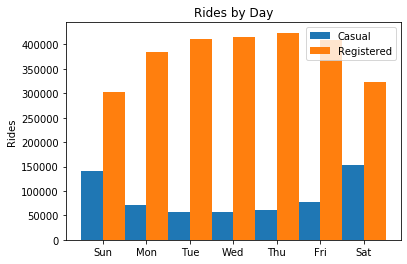

In [6]:
bikes_df_raw['day'] = bikes_df_raw['dteday'].apply(lambda x : x.day)
bikes_grouped = bikes_df_raw.groupby(['year', 'month', 'day'])
day_means = bikes_grouped.mean()
day_maxes = bikes_grouped.max()
day_sums = bikes_grouped.sum()
bikes_by_day = pd.DataFrame(
    0,
    index= np.arange(len(day_means)),
    columns=['dteday', 'weekday', 'weather', 'season', 'temp', 'atemp', 'windspeed', 'hum', 'casual', 'registered', 'counts']
)
bikes_by_day = bikes_by_day.astype(
    {
        'dteday': 'datetime64[ns]',
        'weekday': 'int64',
        'weather': 'int64',
        'season': 'int64',
        'temp': 'float64',
        'atemp': 'float64',
        'windspeed': 'float64',
        'hum': 'float64',
        'casual': 'int64',
        'registered': 'int64',
        'counts': 'int64'
    }
)

def get_timestamp_at_noon(timestamp):
    return pd.Timestamp(timestamp.year, timestamp.month, timestamp.day, 12)
for x in ['weekday', 'season', 'temp', 'atemp', 'windspeed', 'hum']:
    bikes_by_day[x] = day_means[x].values
for x in ['dteday', 'weather']:
    bikes_by_day[x] = day_maxes[x].values
for x in ['casual', 'registered', 'counts']:
    bikes_by_day[x] = day_sums[x].values
bikes_by_day['dteday'] = bikes_by_day['dteday'].apply(lambda x : get_timestamp_at_noon(x)).values

# SRC: https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py
weekday_bikes_by_day = bikes_by_day.groupby('weekday').sum()
days_of_week = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
x = np.arange(len(days_of_week))
width = 0.5
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, weekday_bikes_by_day['casual'], width, label='Casual')
rects2 = ax.bar(x + width/2, weekday_bikes_by_day['registered'], width, label='Registered')
ax.set_title('Rides by Day')
ax.set_xticklabels(days_of_week)
ax.set_xticks(x)
ax.set_ylabel('Rides')
ax.legend()
plt.show()

**2.2 Use `bikes_by_day` to visualize how the distribution...**

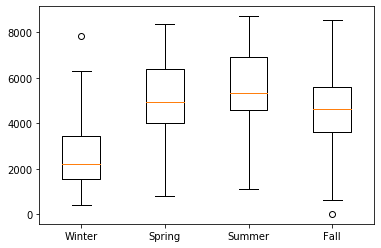

441   2012-03-17 12:00:00
Name: dteday, dtype: datetime64[ns]
667   2012-10-29 12:00:00
Name: dteday, dtype: datetime64[ns]


In [7]:
fig, ax = plt.subplots()
season_bikes_by_day = []
for x in range(1,5):
    season_bikes = bikes_by_day.loc[bikes_by_day['season']==x]['counts']
    season_bikes_by_day.append(season_bikes)

seasons = ['Winter', 'Spring', 'Summer', 'Fall']
results = ax.boxplot(season_bikes_by_day, labels=seasons)
plt.show()

outliers = results['fliers']
winter_outlier_val = outliers[0].get_data()[1][0]
fall_outlier_val = outliers[3].get_data()[1][0]

print((bikes_by_day.loc[bikes_by_day['counts']==winter_outlier_val])['dteday']) # Outlier: St. Patrick's Day
print((bikes_by_day.loc[bikes_by_day['counts']==fall_outlier_val])['dteday']) # Outlier: Hurricane Sandy 

**2.3 Convert the categorical attributes...**

In [8]:
bikes_df = pd.DataFrame(bikes_by_day)
def dummify(src, tgt, var):
    dummies = pd.get_dummies(src[var], prefix=var)
    for x in dummies.columns.values:
        tgt[x] = dummies[x]
bikes_by_day['month'] = bikes_by_day['dteday'].apply(lambda x : x.month).values
dummify(bikes_by_day, bikes_df, 'season')
dummify(bikes_by_day, bikes_df, 'month')
dummify(bikes_by_day, bikes_df, 'weekday')
dummify(bikes_by_day, bikes_df, 'weather')
bikes_by_day.describe()

,weekday,weather,season,temp,atemp,windspeed,hum,casual,registered,counts,...,weekday_1.0,weekday_2.0,weekday_3.0,weekday_4.0,weekday_5.0,weekday_6.0,weather_1,weather_2,weather_3,weather_4
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,...,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,2.997264,2.207934,2.496580,0.495385,0.474354,0.190486,0.627894,848.176471,3656.172367,4504.348837,...,0.143639,0.142271,0.142271,0.142271,0.142271,0.143639,0.206566,0.383037,0.406293,0.004104
std,2.004787,0.766056,1.110807,0.183051,0.162961,0.077498,0.142429,686.622488,1560.256377,1937.211452,...,0.350963,0.349567,0.349567,0.349567,0.349567,0.350963,0.405119,0.486460,0.491477,0.063974
min,0.000000,1.000000,1.000000,0.059130,0.079070,0.022392,0.000000,2.000000,20.000000,22.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,2.000000,2.000000,0.337083,0.337842,0.134950,0.520000,315.500000,2497.000000,3152.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,2.000000,3.000000,0.498333,0.486733,0.180975,0.626667,713.000000,3662.000000,4548.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.000000,3.000000,3.000000,0.655417,0.608602,0.233215,0.730208,1096.000000,4776.500000,5956.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,6.000000,4.000000,4.000000,0.861667,0.840896,0.507463,0.972500,3410.000000,6946.000000,8714.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**2.4 Split the updated `bikes_df` dataset into a 50-50 train-test split...** 

In [9]:
# SRC: https://stackoverflow.com/questions/36997619/sklearn-stratified-sampling-based-on-a-column

X = bikes_df[bikes_df.columns.difference(['count', 'registered', 'casual'])]
y = bikes_df['counts']
bikes_train, bikes_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=X['month'].values, random_state=90)
bikes_train.describe()

,atemp,counts,hum,month,month_1,month_10,month_11,month_12,month_2,month_3,...,weather_4,weekday,weekday_0.0,weekday_1.0,weekday_2.0,weekday_3.0,weekday_4.0,weekday_5.0,weekday_6.0,windspeed
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,...,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,0.473889,4507.958904,0.623392,6.526027,0.084932,0.084932,0.082192,0.084932,0.076712,0.084932,...,0.005479,2.991781,0.147945,0.134247,0.136986,0.161644,0.142466,0.131507,0.145205,0.189920
std,0.157732,1909.999918,0.144771,3.452584,0.279162,0.279162,0.275034,0.279162,0.266500,0.279162,...,0.073922,1.997922,0.355533,0.341385,0.344305,0.368629,0.350007,0.338418,0.352791,0.079867
min,0.079070,506.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.042304
25%,0.342162,3194.000000,0.522083,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.133100
50%,0.480425,4539.000000,0.621250,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.177867
75%,0.607975,5847.000000,0.722174,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.233221
max,0.840896,8714.000000,0.972500,12.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.507463


**2.5 Although we asked you to create your train and test set...**

In [10]:
BSS_train = pd.read_csv('data/BSS_train.csv').drop(columns=['dteday'])
BSS_test = pd.read_csv('data/BSS_test.csv').drop(columns=['dteday'])
BSS_train.describe()

,hour,holiday,year,workingday,temp,atemp,hum,windspeed,casual,registered,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
count,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,...,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000
mean,11.597537,0.029347,0.503395,0.683048,0.496405,0.475399,0.625256,0.190616,35.847623,154.533893,...,0.085280,0.144205,0.137875,0.141788,0.144551,0.143975,0.146047,0.257567,0.083324,0.000230
std,6.960206,0.168788,0.500017,0.465316,0.192561,0.171993,0.192281,0.123252,49.616000,151.500926,...,0.279314,0.351318,0.344789,0.348853,0.351667,0.351085,0.353173,0.437319,0.276387,0.015171
min,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,0.000000,0.000000,0.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,12.000000,0.000000,1.000000,1.000000,0.500000,0.484800,0.620000,0.194000,17.000000,117.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,18.000000,0.000000,1.000000,1.000000,0.660000,0.621200,0.780000,0.253700,49.000000,221.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,23.000000,1.000000,1.000000,1.000000,0.980000,0.984800,1.000000,0.850700,362.000000,886.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**2.6 Use pandas' `scatter_matrix` command to visualize...**

"\nCounts, casual, and registered are all clearly inter-dependent (this isn't surprising as counts == registered + casual)\nTemp and atemp are clearly interdependent (again unsurprising due to definition)\nLooks like there are some weird outliers in temp vs. atemp. Not sure what's happening there.\n"

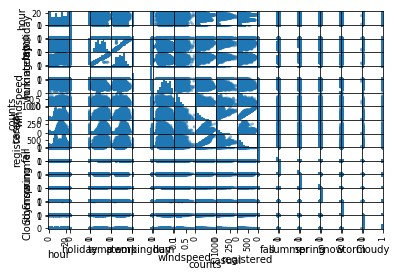

In [11]:
cor_columns = ['hour', 'holiday', 'temp', 'atemp',
               'workingday', 'hum', 'windspeed',
               'counts', 'casual', 'registered',
               'fall', 'summer', 'spring',
               'Snow', 'Storm', 'Cloudy']
scatter_matrix(BSS_train[cor_columns])
# plt.show()

'''
Counts, casual, and registered are all clearly inter-dependent (this isn't surprising as counts == registered + casual)
Temp and atemp are clearly interdependent (again unsurprising due to definition)
Looks like there are some weird outliers in temp vs. atemp. Not sure what's happening there.
'''

**2.7 Make a plot showing the _average_ number of casual and registered riders...**

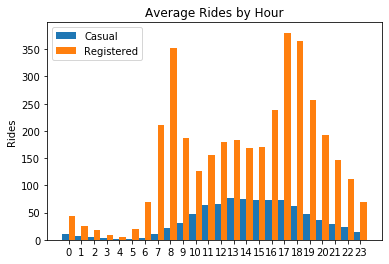

'\nCasual riders seem to be based on daylight hours whereas registered riders seem to be using the bikes for their commute.\nNote how registered riders spike at rush hour.\n'

In [12]:
def blank_pad(series):
    for idx in range(0,24):
        if not idx in series.index:
            series = series.append(pd.Series([0], index=[idx]))
    series = series.sort_index()
    return series

def rider_bar_graph(df, ax, title):
    casual_by_hour = df.groupby('hour').mean()['casual']
    registered_by_hour = df.groupby('hour').mean()['registered']
    casual_by_hour = blank_pad(casual_by_hour)
    registered_by_hour = blank_pad(registered_by_hour)
    x = np.arange(24)
    width = 0.5
    ax.bar(x - width/2, casual_by_hour, width, label='Casual')
    ax.bar(x + width/2, registered_by_hour, width, label='Registered')
    ax.set_title(title)
    ax.set_xticklabels(range(0,24))
    ax.set_xticks(x)
    ax.set_ylabel('Rides')
    ax.legend()

f, ax = plt.subplots()
rider_bar_graph(BSS_train, ax, 'Average Rides by Hour')
plt.show()
'''
Casual riders seem to be based on daylight hours whereas registered riders seem to be using the bikes for their commute.
Note how registered riders spike at rush hour.
'''

**2.8 Use the weather related variables to show how each weather...** 

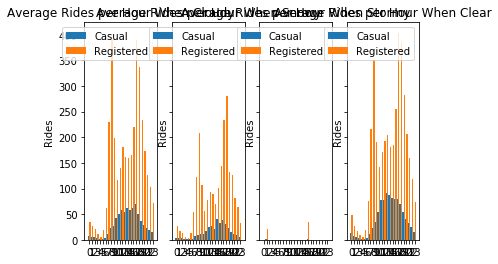

'\nStorms have a major effect on ridership. Snow has some effect, but not as much as I expected.\nClouds seem to be equivalent to clear skies for bike riders.\n'

In [13]:
# SRC: https://stackoverflow.com/questions/26886653/pandas-create-new-column-based-on-values-from-other-columns-apply-a-function-o
def get_clear_weather(row):
    return int(not row['Cloudy'] and not row['Storm'] and not row['Snow'])

BSS_train['Clear'] = BSS_train.apply(lambda row : get_clear_weather(row), axis=1)
BSS_test['Clear'] = BSS_test.apply(lambda row : get_clear_weather(row), axis=1)

f, axes = plt.subplots(1, 4, sharey=True)
rider_bar_graph(BSS_train[BSS_train['Cloudy'] == 1], axes[0], 'Average Rides per Hour When Cloudy')
rider_bar_graph(BSS_train[BSS_train['Snow'] == 1], axes[1], 'Average Rides per Hour When Snowy')
rider_bar_graph(BSS_train[BSS_train['Storm'] == 1], axes[2], 'Average Rides per Hour When Stormy')
rider_bar_graph(BSS_train[BSS_train['Clear'] == 1], axes[3], 'Average Rides per Hour When Clear')
plt.show()

'''
Storms have a major effect on ridership. Snow has some effect, but not as much as I expected.
Clouds seem to be equivalent to clear skies for bike riders.
'''

---

<div class='exercise'> <b> Question 3 [18pts]: Multiple Linear Regression to Predict Hourly Ridership </b> </div>


**3.1** Use statsmodels to fit a multiple linear regression model to the training set using all the useable predictors (nothing that `count` was derived of and no interactions or polynomial terms) to predict `counts`, and report its $R^2$ score on the train and test sets.  Call this set of predictors `X_train`.

**3.2** Examine the estimated coefficients and report which ones are statistically significant at a significance level of 5% (p-value < 0.05). 

**3.3** You should see some strange estimates for the predictors representing months.  Carefully interpret the `July` coefficient, and explain why this result is likely occurring (be as specific as possible). 

**3.4** To diagnose the model, make two plots: first a histogram of the residuals, and second a plot of the residuals of the fitted model ${e} = y - \hat{y}$ as a function of the predicted value $\hat{y}$. Draw a horizontal line denoting the zero residual value on the Y-axis. What do the plots reveal about the OLS assumptions (linearity, constant variance, and normality)?

**3.5** Perhaps we can do better via a model with polynomial terms. Build a dataset `X_train_poly` from your `X_train` data from question 3.1 with added $x^2$ terms for `temp`, `hour`, and `humidity`. Are these polynomial terms important? How does predicted ridership change as each of `temp`, `hour`, and `humidity` increase?

**3.6** You should have received a warning regarding the presence of _multicolinearity_ in the model in 3.1.  Create a new dataset `X_train_drop` by dropping the following predictors from `X_train`:  `workingday` `atemp` `spring` `summer` and `fall` and fit a multiple linear regression model to the variables the remain.  Are the estimates more sensible in this model?  And explain in your own words why multicolinearity can lead to erroneous coefficient values.



### Answers

**3.1 Use statsmodels to fit a multiple linear regression model...**

In [14]:
result_column = 'counts'
interdependent_columns = ['counts', 'registered', 'casual', 'atemp', 'Storm', 'Snow', 'Cloudy', 'Clear']
X_train = BSS_train[BSS_train.columns.difference(interdependent_columns)]
X_train = sm.add_constant(X_train)
X_test = BSS_test[BSS_test.columns.difference(interdependent_columns)]
X_test = sm.add_constant(X_test)

y_train = BSS_train[result_column]
y_test = BSS_test[result_column]
model = OLS(y_train,X_train).fit()
model.summary() # R^2 = 0.411

pred_train = model.predict(X_train)
pred_test = model.predict(X_test)
print(r2_score(pred_train, y_train))
print(r2_score(pred_test, y_test))

-0.4448576472649992
-0.4398646897039271


**3.2 Examine the estimated coefficients and report...**

In [15]:


# STATISTICALLY SIGNIFICANT
'''
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Apr          -44.3600     12.637     -3.510      0.000     -69.132     -19.588
Aug          -61.5561     15.010     -4.101      0.000     -90.979     -32.134
Dec          -18.8023      9.562     -1.966      0.049     -37.545      -0.059
Jul          -93.0475     15.368     -6.055      0.000    -123.172     -62.923
Jun          -74.4792     13.674     -5.447      0.000    -101.283     -47.676
May          -51.3484     13.488     -3.807      0.000     -77.789     -24.908
Nov          -32.4080     12.052     -2.689      0.007     -56.033      -8.783
Sat           12.5889      5.589      2.253      0.024       1.634      23.544
fall          71.4511      9.449      7.562      0.000      52.928      89.974
holiday      -20.0306      8.364     -2.395      0.017     -36.426      -3.635
hour           7.2081      0.233     30.961      0.000       6.752       7.664
hum         -200.1780      9.903    -20.213      0.000    -219.591    -180.765
spring        50.6888      9.528      5.320      0.000      32.012      69.365
summer        22.8938     11.141      2.055      0.040       1.054      44.733
temp         422.1501     16.977     24.866      0.000     388.872     455.429
workingday    11.0216      3.513      3.138      0.002       4.136      17.907
year          78.0900      3.021     25.846      0.000      72.167      84.013
==============================================================================
'''

'\n==============================================================================\n                 coef    std err          t      P>|t|      [0.025      0.975]\n------------------------------------------------------------------------------\nApr          -44.3600     12.637     -3.510      0.000     -69.132     -19.588\nAug          -61.5561     15.010     -4.101      0.000     -90.979     -32.134\nDec          -18.8023      9.562     -1.966      0.049     -37.545      -0.059\nJul          -93.0475     15.368     -6.055      0.000    -123.172     -62.923\nJun          -74.4792     13.674     -5.447      0.000    -101.283     -47.676\nMay          -51.3484     13.488     -3.807      0.000     -77.789     -24.908\nNov          -32.4080     12.052     -2.689      0.007     -56.033      -8.783\nSat           12.5889      5.589      2.253      0.024       1.634      23.544\nfall          71.4511      9.449      7.562      0.000      52.928      89.974\nholiday      -20.0306      8.364     

**3.3 You should see some strange estimates for the predictors representing months...** 

It's odd that all the significant month coefficients seem to be negative. There's probably interdependence with seasons, which all seem to be positive.
The July coefficient is very negative, but it also has a relatively wide range of potential values (see the right two columns).
I think July's range of values is likely so wide because there's a high variance in weather, temperature, and holidays during the month.
Moreover, Washington, DC can be very hot in July, so it makes sense people may not want to ride bikes.


**3.4 To diagnose the model, make two plots:...**

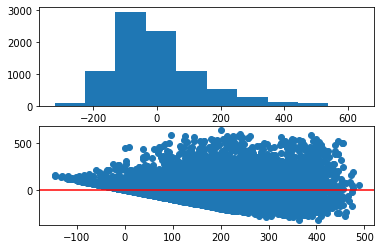

'\nThe histogram shows that our model tends to underestimate the number of rides.\nThe residual plot shows a clear pattern, suggesting we have a colinearity problem in our model.\n'

In [16]:
residuals = model.resid
f, axes = plt.subplots(2)
axes[0].hist(residuals)
axes[1].scatter(pred_train, residuals)
# SRC https://stackoverflow.com/questions/40516661/adding-line-to-scatter-plot-using-pythons-matplotlib

axes[1].axhline(y=0, color='red')
plt.show()
'''
The histogram shows that our model tends to underestimate the number of rides.
The residual plot shows a clear pattern, suggesting we have a colinearity problem in our model.
'''

**3.5 Perhaps we can do better via a model...**

In [17]:
X_train_poly = X_train.copy()
def sq_column(df, column):
    df[column+'^2'] = df[column]**2 # Add square column
    df = df[df.columns.difference([column])] # Remove now dependent column
    return df

X_train_poly = sq_column(X_train_poly, 'temp')
X_train_poly = sq_column(X_train_poly, 'hour')
X_train_poly = sq_column(X_train_poly, 'hum')

model_poly = OLS(y_train,X_train_poly).fit()
pred_train_poly = model.predict(X_train_poly)

# They're certainly important (all have p values far below .05)
# Note: I removed non-polynomial temp, hum, and hour because I was concerned about interdependent variables

'''
STATISTICALLY SIGNIFICANT
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Apr          -29.6012     12.710     -2.329      0.020     -54.516      -4.686
Aug          -71.3115     15.047     -4.739      0.000    -100.808     -41.815
Jul         -117.1690     15.540     -7.540      0.000    -147.631     -86.707
Jun          -86.6098     13.644     -6.348      0.000    -113.355     -59.865
May          -48.3453     13.436     -3.598      0.000     -74.683     -22.008
Sat           11.6177      5.751      2.020      0.043       0.345      22.891
fall          75.1080      9.716      7.730      0.000      56.062      94.154
holiday      -25.1786      8.611     -2.924      0.003     -42.058      -8.299
hour^2         0.1964      0.010     20.224      0.000       0.177       0.215
hum^2       -176.8268      8.222    -21.507      0.000    -192.944    -160.710
spring        56.0514      9.804      5.717      0.000      36.834      75.269
temp^2       488.8528     16.913     28.904      0.000     455.699     522.007
workingday    12.3383      3.615      3.413      0.001       5.252      19.425
year          77.6895      3.103     25.039      0.000      71.607      83.772
==============================================================================
'''

'\nSTATISTICALLY SIGNIFICANT\n==============================================================================\n                 coef    std err          t      P>|t|      [0.025      0.975]\n------------------------------------------------------------------------------\nApr          -29.6012     12.710     -2.329      0.020     -54.516      -4.686\nAug          -71.3115     15.047     -4.739      0.000    -100.808     -41.815\nJul         -117.1690     15.540     -7.540      0.000    -147.631     -86.707\nJun          -86.6098     13.644     -6.348      0.000    -113.355     -59.865\nMay          -48.3453     13.436     -3.598      0.000     -74.683     -22.008\nSat           11.6177      5.751      2.020      0.043       0.345      22.891\nfall          75.1080      9.716      7.730      0.000      56.062      94.154\nholiday      -25.1786      8.611     -2.924      0.003     -42.058      -8.299\nhour^2         0.1964      0.010     20.224      0.000       0.177       0.215\nhum^2     

**3.6 You should have received a warning regarding the presence of _multicollinearity_...**

In [18]:
X_train_drop = X_train.copy()
X_train_drop = X_train_drop[X_train_drop.columns.difference(['workingday', 'atemp', 'spring', 'summer', 'fall'])] # Remove now dependent column
model_drop = OLS(y_train, X_train_drop).fit()
"""
                            OLS Regression Results
==============================================================================
Dep. Variable:                 counts   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.403
Method:                 Least Squares   F-statistic:                     226.9
Date:                Wed, 09 Oct 2019   Prob (F-statistic):               0.00
Time:                        20:15:15   Log-Likelihood:                -55263.
No. Observations:                8689   AIC:                         1.106e+05
Df Residuals:                    8662   BIC:                         1.108e+05
Df Model:                          26
Covariance Type:            nonrobust
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Aug          -40.9043     11.043     -3.704      0.000     -62.551     -19.258
Dec           26.2086      7.582      3.457      0.001      11.346      41.071
Fri           13.5104      5.640      2.396      0.017       2.455      24.566
Jul          -72.2768     11.583     -6.240      0.000     -94.982     -49.571
Jun          -35.3982     10.671     -3.317      0.001     -56.316     -14.480
Nov           38.3870      7.796      4.924      0.000      23.106      53.668
Oct           54.0377      8.686      6.221      0.000      37.010      71.065
Sat           12.3255      5.614      2.196      0.028       1.321      23.330
Tue           11.4788      5.705      2.012      0.044       0.295      22.663
holiday      -37.2529      9.390     -3.967      0.000     -55.659     -18.846
hour           7.2218      0.234     30.871      0.000       6.763       7.680
hum         -198.2002      9.944    -19.933      0.000    -217.692    -178.709
temp         425.3856     16.922     25.137      0.000     392.214     458.557
year          77.9687      3.035     25.691      0.000      72.020      83.918
==============================================================================
Omnibus:                     1712.709   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3312.120
Skew:                           1.202   Prob(JB):                         0.00
Kurtosis:                       4.837   Cond. No.                     1.44e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.83e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""
'''
Looks like the month coefficients stopped being completely negative. This makes sense since some of the removed columns were correlated to month and highly positive.
Now it seems that cold months have positive coefficients while warm months have negative coefficients.
Again, this makes sense since DC is very hot in the summer.
'''

'\nLooks like the month coefficients stopped being completely negative. This makes sense since some of the removed columns were correlated to month and highly positive.\nNow it seems that cold months have positive coefficients while warm months have negative coefficients.\nAgain, this makes sense since DC is very hot in the summer.\n'

---

<div class='exercise'> <b> Question 4 [20pts]: Regression Models with Polynomial and Interaction Terms </b> </div>

**4.1** Drop the variables `workingday`, `atemp`, `spring`, `summer`, `fall`, and  `dteday` from `BSS_train` (if any of them still remain).

**4.2** Write a function to standardize a provided subset of columns in your training/validation/test sets. Remember that while you will be scaling all of your data, you must learn the scaling parameters (mean and SD) from only the training set.

Test your code by building a list of all non-binary columns from `X_train` into a dataset called `practice_X_train` and scaling only those columns. Call the result `practice_X_train_scaled`. Display the `.describe()` and verify that you have correctly scaled all columns, including the polynomial columns.

**Hint: employ the provided list of binary columns and use `pd.columns.difference()`**

`binary_columns = [ 'holiday', 'workingday','Feb', 'Mar', 'Apr',
       'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'spring',
       'summer', 'fall', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
       'Cloudy', 'Snow', 'Storm']`


**4.3** Write a code to augment your a dataset with higher-order features for `temp`, `hum`,`windspeed`, and `hour`. You should include ONLY the pure powers of these columns. So with degree=2 you should produce `temp^2` and `hum^2` but not `temp*hum` or any other two-feature interactions. 

Encapsulate this process as a function with appropriate inputs and outputs, and test your code by producing `practice_X_train_poly`, a training dataset with quadratic and cubic features built from `practice_X_train_scaled`, and printing `practice_X_train_poly`'s column names and `.head()`.

**4.4** Write code to add interaction terms to the model. Specifically, we want interactions between the continuous predictors (`temp`, `hum`,`windspeed`) and the month and weekday dummies (`Feb`, `Mar`...`Dec`, `Mon`, `Tue`, ... `Sat`). That means you SHOULD build `temp*Feb` and `hum*Mon` and so on, but NOT `Feb*Mar` and NOT `Feb*Tue`. The interaction terms should always be a continuous feature times a month dummy or a continuous feature times a weekday dummy.

Encapsulate this process as a function with appropriate inputs and outputs, and test your code by adding interaction terms to `practice_X_train_poly` and show its column names and `.head()`**

**4.5** Combine all your code so far into a function named `get_design_mats` that takes in `BSS_train`, `BSS_test`, the names of columns for polynomial, the target column, the columns to be dropped and produces computation-ready design matrices `X_train` and `X_test` and responses `y_train` and `y_test`. Your final function should build correct, scaled design matrices with the stated interaction terms and any polynomial degree.


**4.6** For each degree in 1 through 8:

1.  Build the training design matrix and validation design matrix using the function `get_design_mats` with polynomial terms up through the specified degree.

2.  Fit a regression model to the training data.

3.  Report the model's score on the test data.

**4.7** Discuss patterns you see in the results from 4.5. Which model would you select, and why?

### Answers

**4.1 Drop...**

In [19]:
BSS_train = BSS_train[BSS_train.columns.difference(['atemp', 'spring', 'summer', 'fall', 'dteday'])]

**4.2 Write a function to standardize...**

In [20]:
binary_columns = [ 'holiday', 'workingday','Feb', 'Mar', 'Apr',
       'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'spring',
       'summer', 'fall', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
       'Cloudy', 'Snow', 'Storm']
scalar_columns = X_train.columns.difference(binary_columns)

practice_X_train = X_train.copy()[scalar_columns]
practice_X_train = practice_X_train[scalar_columns]
scaler = StandardScaler()
scaler.fit(practice_X_train)

def scale_df(df, scalar_columns, scaler):
    scaled_df = df.copy()[scalar_columns]
    return pd.DataFrame(scaler.transform(scaled_df), columns=scaled_df.columns)

practice_X_train_scaled = scale_df(X_train, scalar_columns, scaler)

**4.3 Write code to augment your a dataset with higher-order features for...**

In [21]:
def add_higher_order(df, deg, columns):
    new_df = df.copy()
    for col in columns:
        for x in range(2,deg+1):
            new_df[col + '^' + str(x)] = new_df[col]**x
    return new_df

practice_X_train_poly = add_higher_order(practice_X_train_scaled, 3, ['hour', 'temp', 'windspeed', 'hum'])
practice_X_train_poly.describe()

,const,hour,hum,temp,windspeed,year,hour^2,hour^3,temp^2,temp^3,windspeed^2,windspeed^3,hum^2,hum^3
count,8689.0,8.689000e+03,8.689000e+03,8.689000e+03,8.689000e+03,8.689000e+03,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000
mean,0.0,2.762461e-17,-4.148227e-16,-7.622961e-17,-5.604141e-17,-2.754411e-16,1.000000,-0.029536,1.000000,-0.003553,1.000000,0.604780,1.000000,-0.117170
std,0.0,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00,0.883775,1.937962,1.031511,2.427744,1.644144,5.603067,1.096835,2.723191
min,0.0,-1.666359e+00,-3.251974e+00,-2.474192e+00,-1.546636e+00,-1.006813e+00,0.003344,-4.627068,0.000349,-15.146077,0.000754,-3.699682,0.000609,-34.390707
25%,0.0,-8.042663e-01,-7.554808e-01,-8.122824e-01,-6.987336e-01,-1.006813e+00,0.238997,-0.520235,0.188486,-0.535946,0.072936,-0.341142,0.153201,-0.431192
50%,0.0,5.782674e-02,-2.733697e-02,1.867233e-02,2.746035e-02,9.932327e-01,0.846252,0.000193,0.659803,0.000007,0.488229,0.000021,0.647747,-0.000020
75%,0.0,9.199197e-01,8.048274e-01,8.496271e-01,5.118601e-01,9.932327e-01,1.825110,0.778484,1.507394,0.613317,1.249853,0.134108,1.620325,0.521325
max,0.0,1.638331e+00,1.949053e+00,2.511537e+00,5.355858e+00,9.932327e-01,2.776753,4.397488,6.307816,15.842311,28.685212,153.633917,10.575333,7.404081


**4.4 Write code to add interaction terms to the model...**

In [22]:

time_cols = [ 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec',
            'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
weather_cols = ['temp', 'hum', 'windspeed']

def add_interactions(df, time_cols, weather_cols):
    new_df = df.copy()
    for time_col in time_cols:
        for weather_col in weather_cols:
            new_df[time_col + '_' + weather_col] = new_df[time_col] * new_df[weather_col]
    return new_df

# Re-add time and weather cols to practice_X_train_poly
for time_col in time_cols:
    practice_X_train_poly[time_col] = X_train[time_col]

for weather_col in weather_cols:
    practice_X_train_poly[weather_col] = X_train[weather_col]

practice_X_train_poly = add_interactions(practice_X_train_poly, time_cols, weather_cols)
practice_X_train_poly.describe()

,const,hour,hum,temp,windspeed,year,hour^2,hour^3,temp^2,temp^3,...,Wed_windspeed,Thu_temp,Thu_hum,Thu_windspeed,Fri_temp,Fri_hum,Fri_windspeed,Sat_temp,Sat_hum,Sat_windspeed
count,8689.0,8.689000e+03,8689.000000,8689.000000,8689.000000,8.689000e+03,8689.000000,8689.000000,8689.000000,8689.000000,...,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000
mean,0.0,2.762461e-17,0.625256,0.496405,0.190616,-2.754411e-16,1.000000,-0.029536,1.000000,-0.003553,...,0.026581,0.072469,0.087798,0.027769,0.071005,0.087275,0.027094,0.069957,0.090495,0.028565
std,0.0,1.000058e+00,0.192281,0.192561,0.123252,1.000058e+00,0.883775,1.937962,1.031511,2.427744,...,0.080497,0.190548,0.226148,0.081036,0.188233,0.224302,0.081786,0.185319,0.231813,0.083733
min,0.0,-1.666359e+00,0.000000,0.020000,0.000000,-1.006813e+00,0.003344,-4.627068,0.000349,-15.146077,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,-8.042663e-01,0.480000,0.340000,0.104500,-1.006813e+00,0.238997,-0.520235,0.188486,-0.535946,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.0,5.782674e-02,0.620000,0.500000,0.194000,9.932327e-01,0.846252,0.000193,0.659803,0.000007,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.0,9.199197e-01,0.780000,0.660000,0.253700,9.932327e-01,1.825110,0.778484,1.507394,0.613317,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.0,1.638331e+00,1.000000,0.980000,0.850700,9.932327e-01,2.776753,4.397488,6.307816,15.842311,...,0.641800,0.920000,1.000000,0.641800,0.980000,1.000000,0.806000,0.960000,1.000000,0.835800


**4.5 Combine all your code so far into a function named...**

In [23]:
def get_design_mats(train_df, val_df,  degree,
                    columns_forpoly=['temp', 'hum','windspeed', 'hour'],
                    target_col='counts',
                    bad_columns=['counts']):
    """
    :param train_df: The training data
    :param val_df: Your test/validation data
    :param columns_forpoly: List containing the column name for which we want to create
                            polynomial terms
    :param target_col: The response variable column
    :param bad_columns: The columns you want to drop
    """

    time_cols = [ 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec',
            'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
    weather_cols = ['temp', 'hum', 'windspeed']

    # Set target values
    y_train = train_df[target_col]
    y_val = val_df[target_col]

    x_train = train_df[train_df.columns.difference(bad_columns)]
    x_train = sm.add_constant(x_train)
    scaler = StandardScaler()
    scaler.fit(x_train[scalar_columns])

    x_train = scale_df(x_train, scalar_columns, scaler)
    x_train = add_higher_order(x_train, degree, columns_forpoly)
    for time_col in time_cols:
        x_train[time_col] = train_df[time_col]
    for weather_col in weather_cols:
        x_train[weather_col] = train_df[weather_col]
    x_train = add_interactions(x_train, time_cols, weather_cols)

    x_val = val_df[val_df.columns.difference(bad_columns)]
    x_val = sm.add_constant(x_val)
    x_val = scale_df(x_val, scalar_columns, scaler)
    x_val = add_higher_order(x_val, degree, columns_forpoly)
    for time_col in time_cols:
        x_val[time_col] = train_df[time_col]
    for weather_col in weather_cols:
        x_val[weather_col] = train_df[weather_col]
    x_val = add_interactions(x_val, time_cols, weather_cols)

    return x_train,y_train, x_val,y_val


**4.6 For each degree in 1 through 8...**

In [24]:
for deg in range(0,9):
    # HACK: Drops one item from validation to make sure sizes match
    x_train,y_train, x_val,y_val = get_design_mats(BSS_train, BSS_test[:-1], deg, bad_columns=['counts', 'casual', 'registered'])
    model = OLS(y_train, x_train).fit()
    y_pred = model.predict(x_val)
    score = r2_score(y_val, y_pred)
    print(score)

-0.04051171566788003
-0.04051171566788003
0.1649124976783597
0.012706655156264013
0.007322914259265234
0.12320588451616399
0.09649422445477374
0.2588667142115473
0.2842179467216389


**4.7 Discuss patterns you see in the results...**

Scores clearly improve as we add more degrees, but we are almost certainly overfitting. We'd want to see how the residuals for the test and training sets diverge as degree increases.

It's also worth noting these scores are still quite low. It may mean our model is flawed, or bike ridership could be particularly hard to predict.

---

<div class='exercise'> <b> Question 5 [20pts]: Regularized Models </b> </div>

**5.1** Let's try regularizing our models via ridge regression. Split the training set, `BSS_train`, into an 80-20 train-validation split.  Build a table showing the validation set $R^2$ of polynomial models with degree from 1-8, regularized at the levels $\lambda = (.01, .05, .1,.5, 1, 5, 10, 50, 100)$. Do not perform cross validation at this point, simply report performance on the single validation set. 

**5.2** Find the best-scoring degree and regularization combination.

**5.3** It's time to see how well our selected model will do on future data. Use the earlier created test dataset, do any required formatting, and report the best model's $R^2$ score. How does it compare to the validation set score that made us choose this model? Does the test set simply have observations that are more difficult or easier to predict?

**5.4** Build a dataset with polynomial degree 1 and fit an OLS model, a Ridge model, and a Lasso model. Use `RidgeCV` and `LassoCV` to select the best regularization level from among `(.1,.5,1,5,10,50,100)`. 

Note: On the lasso model, you may need to increase `max_iter` (start with 100,000) for the optimization to converge.

**5.5** Plot histograms of the coefficients found by each of OLS, ridge, and lasso. What trends do you see in the magnitude of the coefficients?

**5.6** The plots above show the overall distribution of coefficient values in each model, but do not show how each model treats individual coefficients. Build a plot which cleanly presents, for each feature in the data, 1) The coefficient assigned by OLS, 2) the coefficient assigned by ridge, and 3) the coefficient assigned by lasso.

**Hint: Bar plots are a possible choice, but you are not required to use them**

**Hint: use `xticks` to label coefficients with their feature names**

**5.7** What trends do you see in the plot above? How do the three approaches handle the correlated pair `temp` and `atemp`?

### Answers

**5.1 Let's try regularizing our models via...** 

In [ ]:
# your code here

**5.2 Find the best-scoring degree and regularization combination.**

In [ ]:
# your code here

**5.3 It's time to see how well our selected model...**


In [ ]:
# your code here

**5.4 Build a dataset with polynomial degree 1...**

In [ ]:
# your code here

**5.5 Plot histograms of the coefficients found...**

In [ ]:
# your code here

**5.6 The plots above show the overall distribution of... **

In [ ]:
# your code here

**5.7 What trends do you see...**

In [ ]:
# your code here

*your answer here*

---

<div class='exercise'> <b> Question 6 [16 pts]: Reflection </b></div>
These problems are open-ended, and you are not expected to write more than 2-3 sentences. We are interested in seeing that you have thought about these issues; you will be graded on how well you justify your conclusions here, not on what you conclude.

**6.1** Reflect back on the `get_design_mats` function you built. In what way was writing this function useful in your analysis? What issues might you have encountered if you copy/pasted the model-building code instead of tying it together in a function? Does a `get_design_mat` function seem wise in general, or are there better options?

**6.2** What are the costs and benefits of applying ridge/lasso regularization to an overfit OLS model, versus setting a specific degree of polynomial or forward selecting polynomial features for the model?

**6.3** This pset posed a purely predictive goal: forecast ridership as accurately as possible. How important is interpretability in this context? Considering, e.g., your lasso and ridge models from Question 5, how would you react if the models predicted well, but the coefficient values didn't make sense once interpreted?

**6.4** Reflect back on our original goal of helping BikeShare predict what demand will be like in the week ahead, and thus how many bikes they can bring in for maintenance. In your view, did we accomplish this goal? If yes, which model would you put into production and why? If not, which model came closest, what other analyses might you conduct, and how likely do you think they are to work?


### Answers

**6.1 Reflect back on the get_design_mats function you built...**

*your answer here*

**6.2 What are the costs and benefits of applying ridge/lasso...**

The main benefit of Ridge/Lasso regularization over polynomial degree selection is that one has a continuous set of choices in the former and a discrete one in the latter. With polynomial degree selection, the model may jump from overfitting the data with a high degree polynomial to underfitting it with the next lowest degree. As such, it is not always possible to find a model that nicely fits the data using this method. Regularization on the other hand, helps smooth out the line by fine-tuning the lambda value, thus controlling how much to penalize high coefficients.

The cost of regularization is that both Ridge and LASSO have their respective downsides. For example, in cases where we have more predictors (p) than observations (n), LASSO can at most select n predictors. It is thus a poorer model when there are many informative predictors. Ridge has the opposite problem, where it does not do feature selection and thus maintains all predictors even if many are uninformative. In those cases, it is not the best-fit model for the data.

**6.3 This pset posed a purely predictive goal: forecast ridership...**

In a purely predictive context where the problem space is well studied and/or the model doesn't have a real-life impact we may not care about interpretability. In cases like these, we may only care about the "What" ie. here: "what is the ridership forecast?". However, in most real-world settings we care about interpretability because we also want to understand the "Why". This is because there could be lots of valuable insights hiding behind observations that in our case could make the difference between BikeShare implementing useful vs detrimental updates to their service. Additionally, it is crucial information to have if something goes wrong after the model has been put into production. Whithout understanding how the predictions came to be, it is much harder to debug and solve errors down the road.

Consequently, if in a real-life scenario the LASSO and Ridge models predicted well but the coefficients didn't make any sense when interpreted I would be concerned and not put it into production until they did.

**6.4 Reflect back on our original goal of helping BikeShare predict...**

*your answer here*